In [1]:
from __future__ import print_function, division
import os, bz2, json, time
from datetime import timedelta

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


import sys
sys.path.insert(0, '../')
from pyhip import HIP

In [2]:
dataset_path = "../data/active-dataset.json.bz2"
vidsOrder_path = "../data/active-dataset-vids-order.json"

output_folder = "../output/active_output"

In [3]:
active_hip_res = {}
for (dirpath, dirnames, dirfiles) in os.walk(output_folder):
    # trivial loop
    for output_json in dirfiles:
        res_path = os.path.join(output_folder, output_json)
        with open(res_path, "r") as infile:
            active_hip_res = {**active_hip_res, **json.loads(infile.readline())}
print("#videos evaluated on HIP:",len(active_hip_res))
vids = list(active_hip_res.keys())
print(vids[0]+":" ,active_hip_res[vids[0]])

#videos evaluated on HIP: 14041
00-6OyXVA0M: {'category': 'Entertainment', 'hipParams': [436.91249394708854, 555.6561615624704, 10.455729533740234, 0.009096105449466808, 0.0, 0.0, 1.0725620759963126, 468.6157715366156], 'predictViewcount': [110975.7734625605, 618748.4265383878, 257258.06635510508, 123137.11162190908, 84790.28534167168, 100109.41854426476, 169304.15340230704, 329963.14732377225, 155581.31787920068, 77810.07187921746, 38032.524295931486, 32283.065155570424, 28398.79686321676, 21145.414434624883, 20654.701124138963, 20621.502881049113, 18434.694449525592, 11733.062820447245, 11716.589618170869, 13026.212637938346, 7434.950184137273, 7930.50931668581, 8400.947888275772, 6685.1245080265135, 7442.868842595107, 7057.220050042333, 3972.742282472278, 5511.717986450817, 4305.096876507967, 728.1653488780993, 1360.0000751826283, 2276.5705977673083, 3649.3168541160903, 1557.6248302094411, 3163.7654994538293, 3272.4257848682837, 1532.1270068003046, 1851.3030125603054, 1872.896236956

## define util funcs

In [4]:
def total_views_at(days, viewcounts, vids, accumulate=True):
    """ compute total number of views at several evaluation days
    :return: a dataframe
    :param accumulate: when false, sum from last day to current day
    """
    viewcount_eval = []
    for i in range(len(viewcounts)):
        if accumulate:
            viewcount_accu = [np.sum(viewcounts[i][:day]) for day in days]
        else:
            viewcount_accu = []
            for j in range(len(days)):
                if j==0: viewcount_accu.append(np.sum(viewcounts[i][:days[j]]))
                else: viewcount_accu.append(np.sum(viewcounts[i][days[j-1]:days[j]]))        
        viewcount_eval.append(viewcount_accu)
    
    df_viewcount_eval = pd.DataFrame(viewcount_eval, columns =days, index = vids)
    return df_viewcount_eval

def pop_perc_at(days, viewcounts, vids, accumulate=True):
    """ compute popularity percentile for a series at several evaluation days
    :param days: list, time points(from day 0) to chop and compute popularity percentile 
    :param viewcounts: list, viewcount history for multiple videos
    :param accumulate: when false, sum from last day to current day
    :return: list of dataframe
    """
    df_viewcount_eval = total_views_at(days, viewcounts, vids, accumulate)
    
    pop_perc_col = np.linspace(0, 1, len(df_viewcount_eval.index))
    pop_percs = []
    for day in days:
        df_viewcount_sort = df_viewcount_eval.loc[:,[day]].sort_values(by=[day], inplace=False)
        df_viewcount_sort[day] = pop_perc_col
        pop_percs.append(df_viewcount_sort)
    return pop_percs

def perc_error(days, percs_pred, percs_gt):
    """ compute HIP prediction percentile error at different days
    """
    perc_error = []
    for i, day in enumerate(days):
        error = []
        perc_pred = percs_pred[i]
        perc_gt = percs_gt[i]
        for ind in perc_pred.index:
            error.append(np.abs(perc_pred.loc[ind, day]-perc_gt.loc[ind, day]))
#         display(pd.DataFrame(error).describe())
        perc_error.append(np.mean(error))
    return perc_error
#     return perc_error, error

def perc_error_cate(days, percs_pred, percs_gt, dataset):
    """ compute HIP prediction percentile error at different days,
        and break down to different categories
    """
    perc_error = []
    for i, day in enumerate(days):
        error = {}
        perc_pred = percs_pred[i]
        perc_gt = percs_gt[i]
        for ind in perc_pred.index:
            if dataset[ind]["category"] in error:
                error[dataset[ind]["category"]].append(np.abs(perc_pred.loc[ind, day]-perc_gt.loc[ind, day]))
            else:
                error[dataset[ind]["category"]] = [np.abs(perc_pred.loc[ind, day]-perc_gt.loc[ind, day])]                
        perc_error.append({cate: np.mean(error[cate]) for cate in error.keys()})
    return perc_error

### read results from file and evaluate
+ train, test done by hip-on-ACTIVE.py

In [5]:
categories = ['Education', 'Music', 'People & Blogs', 'News & Politics', 'Nonprofits & Activism',\
              'Film & Animation', 'Entertainment', 'Sports', 'Howto & Style', 'Travel & Events',\
              'Gaming', 'Autos & Vehicles', 'Comedy', 'Science & Technology', 'Pets & Animals', 'Shows', 'NA']

In [6]:
# train params
num_train = 90
num_test = 30
num_initialization = 25
days = [num_train,num_train+num_test] # days = [num_train+num_test//2,num_train+num_test] # days = [num_train+num_test-1,num_train+num_test]

In [7]:
# compute forecasting error on whole dataset
# get veiwcounts series and corrsponding popularity percentile
viewcounts_pred = [active_hip_res[vid]["predictViewcount"] for vid in vids] # (No.vids x 120)
viewcounts_gt = [active_hip_res[vid]["dailyViewcount"] for vid in vids]

pop_percs_pred = pop_perc_at(days, viewcounts_pred, vids, accumulate=False)
pop_percs_gt = pop_perc_at(days, viewcounts_gt, vids, accumulate=False)

mAPE = perc_error(days, pop_percs_pred, pop_percs_gt)
print("Mean absolute percentile error at {}:{}".format(days, mAPE))
mAPE_cate = perc_error_cate(days, pop_percs_pred, pop_percs_gt, active_hip_res)
print("Mean absolute percentile error at {}:\n{}".format(days, mAPE_cate))

Mean absolute percentile error at [90, 120]:[0.004181851642858694, 0.06542352260605946]
Mean absolute percentile error at [90, 120]:
[{'NA': 0.004008517608969076, 'People & Blogs': 0.0050881873961301045, 'Music': 0.0036679244547447643, 'Education': 0.003573023806074655, 'Entertainment': 0.0038146118555475264, 'Howto & Style': 0.0037236048265460076, 'Film & Animation': 0.0047066859932357015, 'Nonprofits & Activism': 0.004706397507953927, 'Shows': 0.002073158323158336, 'Gaming': 0.0034333558793990444, 'News & Politics': 0.004801271259604593, 'Science & Technology': 0.005974662340403081, 'Comedy': 0.0042007706531155846, 'Travel & Events': 0.0034393491124260368, 'Sports': 0.004474440043545735, 'Pets & Animals': 0.006089743589743586, 'Autos & Vehicles': 0.00668431809736158}, {'News & Politics': 0.0767219200552534, 'People & Blogs': 0.07515177061075498, 'Film & Animation': 0.0663223427355981, 'Sports': 0.08589410627012252, 'Entertainment': 0.06530415112286457, 'Travel & Events': 0.0997164694

In [8]:
# drop 'NA' videos and small-category videos
# categories_todrop = ["Autos & Vehicles", "Travel & Events", "Pets & Animals", "Shows", "Movies", "Trailers", 'NA']
# vids_clean = list(filter(lambda vid: active_hip_res[vid]["category"] not in categories_todrop, vids))

# viewcounts_pred_clean = [active_hip_res[vid]["predictViewcount"] for vid in vids_clean] # (No.vids x 120)
# viewcounts_gt_clean = [active_hip_res[vid]["dailyViewcount"] for vid in vids_clean]
# print("#videos after dropping some categories:",len(viewcounts_gt_clean))

# pop_percs_pred_clean = pop_perc_at(days, viewcounts_pred_clean, vids_clean, accumulate=False)
# pop_percs_gt_clean = pop_perc_at(days, viewcounts_gt_clean, vids_clean, accumulate=False)

# mAPE_clean = perc_error(days, pop_percs_pred_clean, pop_percs_gt_clean)
# print("Mean absolute percentile error at {}:{}".format(days, mAPE_clean))
# mAPE_cate_clean = perc_error_cate(days, pop_percs_pred_clean, pop_percs_gt_clean, active_hip_res)
# print("Mean absolute percentile error at {}:\n{}".format(days, mAPE_cate_clean))

# Mean absolute percentile error at [90, 120]:[0.0041962034217382154, 0.06502507056099296]

## Reproduce result: analysis and visualization

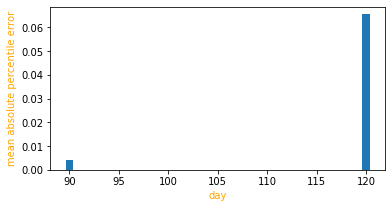

In [9]:
# mAPE
figure1 = plt.figure(figsize=(6,3))
ax1 = figure1.add_subplot(111)
ax1.bar(days, mAPE)
ax1.set_xlabel("day", color="orange")
ax1.set_ylabel("mean absolute percentile error", color="orange")
pass

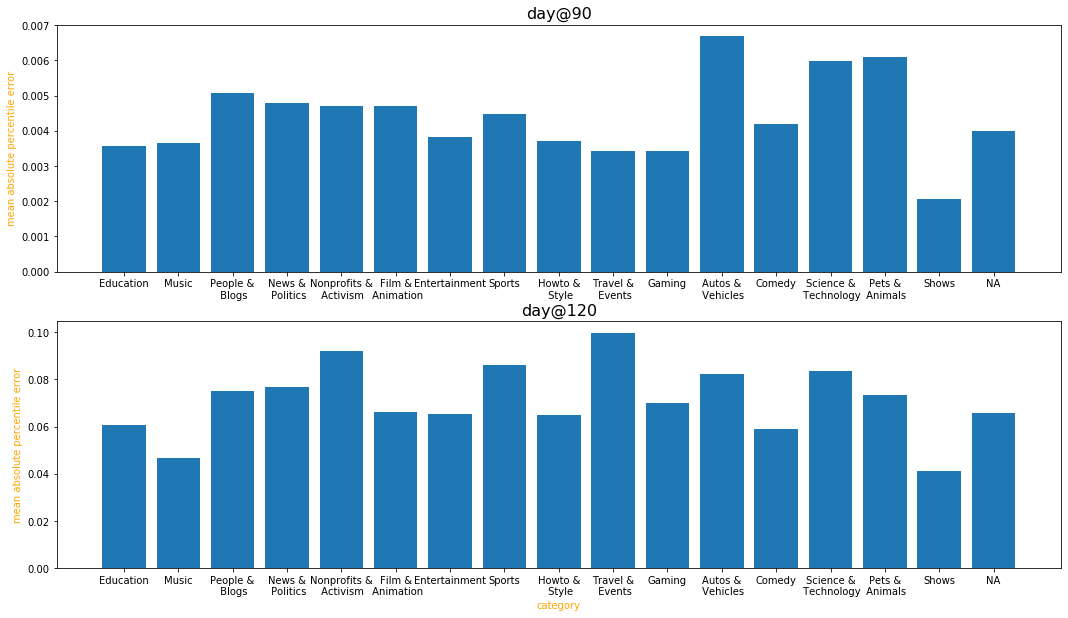

In [10]:
# mAPE by category
figure2 = plt.figure(figsize=(18,10))
ax2 = figure2.add_subplot(211)
ax2.bar([cate.replace("&","&\n") for cate in categories], [mAPE_cate[0][cate] for cate in categories])
ax2.set_title("day@{}".format(days[0]))
ax2.set_ylabel("mean absolute percentile error", color="orange")
ax2 = figure2.add_subplot(212)
ax2.bar([cate.replace("&","&\n") for cate in categories], [mAPE_cate[1][cate] for cate in categories])
ax2.set_title("day@{}".format(days[1]))
ax2.set_ylabel("mean absolute percentile error", color="orange")
ax2.set_xlabel("category", color="orange")
pass

## daily viewcount analysis (no HIP involved)

array([[281.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 281.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 281., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 281.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 281.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 281.]])

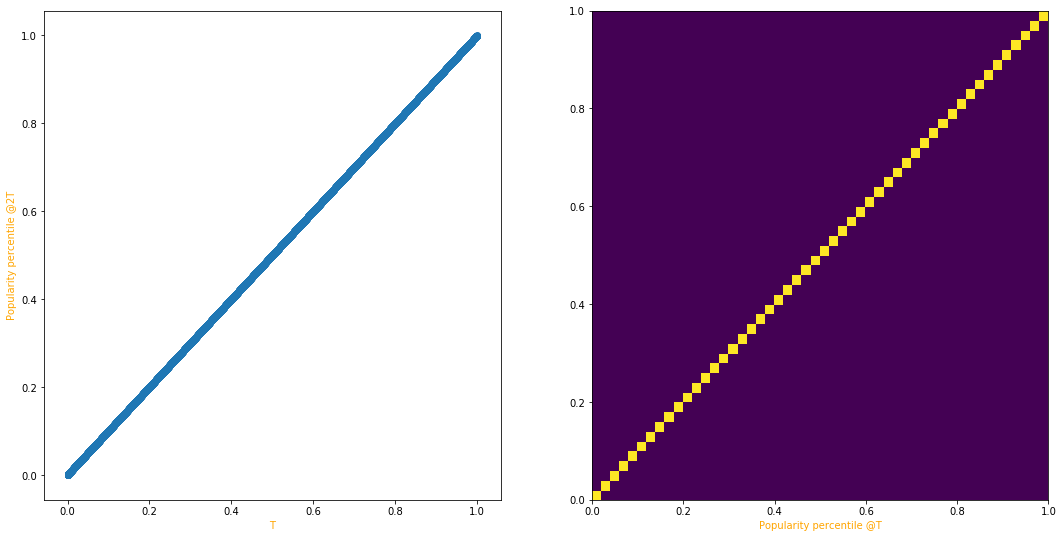

In [14]:
# T vs 2T
T = 30
days2 = [T, 2*T]
pop_percs_gt = pop_perc_at(days2, viewcounts_gt, vids, True)
figure = plt.figure(figsize=(18,9))
ax = figure.add_subplot(121)
ax.scatter(pop_percs_gt[0][days2[0]], pop_percs_gt[1][days2[1]])
ax.set_ylabel("Popularity percentile @2T", color="orange")
ax.set_xlabel("T", color="orange")
ax = figure.add_subplot(122)
ax.set_xlabel("Popularity percentile @T", color="orange")
ax.hist2d(pop_percs_gt[0][T], pop_percs_gt[1][2*T], bins=50)[0]

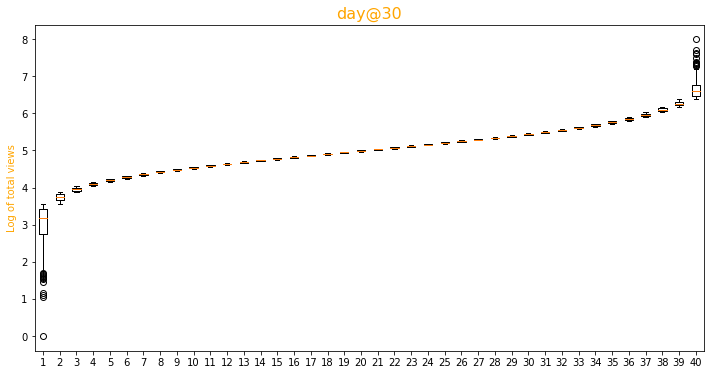

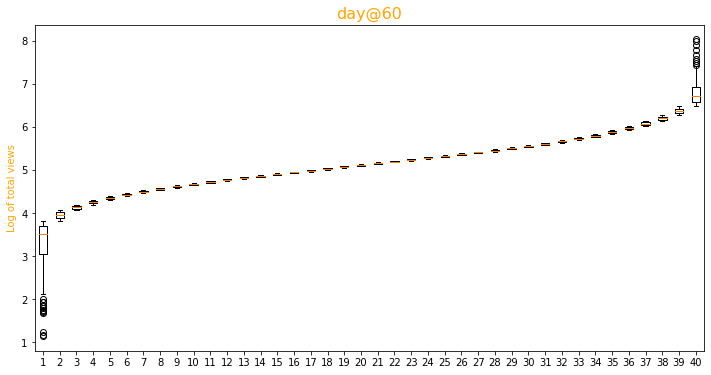

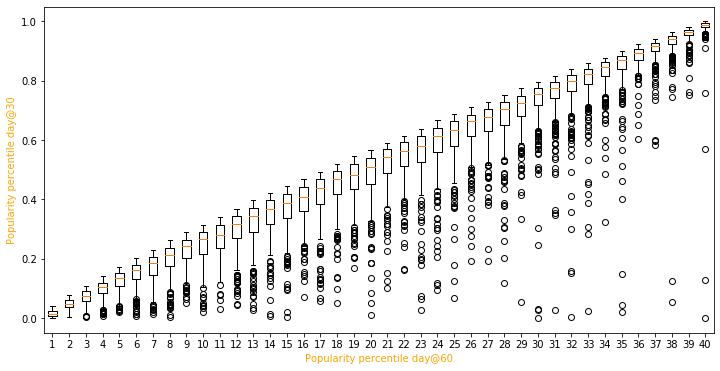

In [12]:
def plot_popPerc_totalViews(days, df_total_views, pop_percs_gt):
    """ assume days to be of length 2
    """
    noBins = 40
    bin_width = 1.0 / noBins
    popPerc_eval = [[] for x in range(noBins)]
    for i in range(len(days)):
        total_views_binned = [[] for x in range(noBins)]
        total_views_log_space = [math.log(max(df_total_views.loc[vid, days[i]], 1), 10) for vid in pop_percs_gt[i].index]
        for j in range(len(pop_percs_gt[i][days[i]])):
            pop_perc = pop_percs_gt[i][days[i]][j]
            noBin = min(int(np.floor(pop_perc / bin_width)), noBins-1)
            total_views_binned[noBin].append(total_views_log_space[j])
#             if noBin==39 and total_views_log_space[j]<3.333:
#                 print(pop_perc)
            if i==1:
                vid = (pop_percs_gt[i].index)[j]
                popPerc_eval[noBin].append(pop_percs_gt[i-1][days[i-1]].loc[vid])

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        ax.boxplot(total_views_binned)
        ax.set_ylabel("Log of total views", color="orange")
        ax.set_title("day@{}".format(days[i]), color="orange")
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.boxplot(popPerc_eval)
    ax.set_ylabel("Popularity percentile day@{}".format(days[0]), color="orange")
    ax.set_xlabel("Popularity percentile day@{}".format(days[1]), color="orange")
    return total_views_binned
#     ax.set_ylabel("Log of total views")            

df_total_views = total_views_at(days2, viewcounts_gt, vids, accumulate=True)
total_views_binned = plot_popPerc_totalViews(days2, df_total_views, pop_percs_gt)